# Create an AOI needed for mosaic of CHM: CAVM - buffer and clip to land

#### Workflow steps: 
1.  `cavm_buffer_above_shrubs.ipynb` --> creates the AOI needed for mosaic
2.  `mosaic_chm_dinvo3.ipynb` --> creates a tiles mosaic of CHM data with masking within AOI
3.  `summarize_chm_dinov3_create.ipynb` --> computes height class summary table
4.  `summarize_chm_dinov3_plot.ipynb` --> uses height class smry to plot bar/donut plot
5.  `map_chm_dinov3.ipynb` --> map corresponding to data plotted from summary

Paul Montesano  
Feb 2026

In [1]:
import geopandas as gpd

In [2]:
cavm_treeline = gpd.read_file('/explore/nobackup/people/pmontesa/userfs02/arc/CAVM_treeline.shp')

/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/../../.././libtiff.so.6: version `LIBTIFF_4.6.1' not found (required by /app/jupyter/ilab/jupyter-lab/prod/lib/gdalplugins/../libgdal.so.36)
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/../../.././libtiff.so.6: version `LIBTIFF_4.6.1' not found (required by /app/jupyter/ilab/jupyter-lab/prod/lib/gdalplugins/../libgdal.so.36)
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/../../.././libtiff.so.6: version `LIBTIFF_4.6.1' not found (required by /app/jupyter/ilab/jupyter-lab/prod/lib/gdalplugins/../libgdal.so.36)
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/../../.././libtiff.so.6: version `LIBTIFF_4.6.1' not found (required by /app/jupyter/ilab/jupyter-lab/prod/lib/gdalplugins/../libgdal.so.36)
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3

In [3]:
cavm_treeline_buf = cavm_treeline.copy()

In [4]:
BUF_KM = 100

In [5]:
cavm_treeline_buf['geometry'] = cavm_treeline.geometry.buffer(BUF_KM * 1000)
cavm_treeline_buf['name'] = 'CAVM'

In [6]:
cavm_treeline_buf

,OBJECTID,Shape_Leng,Shape_Le_1,geometry,name
0,1,90081.584060,90081.584060,"POLYGON ((593195.081 2516954.775, 588654.065 2...",CAVM
1,2,21475.308575,21475.308575,"POLYGON ((752501.237 2619079.621, 753049.746 2...",CAVM
2,3,27245.470377,27245.470377,"POLYGON ((797800.592 2422833.554, 792565.805 2...",CAVM
3,4,48732.406048,48732.406048,"POLYGON ((843885.615 2413826.083, 839749.362 2...",CAVM
4,5,21626.699279,21626.699279,"POLYGON ((907356.735 2400413.246, 906214.542 2...",CAVM
...,...,...,...,...,...
150,151,72094.189529,72094.189529,"POLYGON ((680799.474 -2680286.230, 679785.676 ...",CAVM
151,152,36102.321069,36102.321069,"POLYGON ((-222619.023 -2550303.138, -218682.71...",CAVM
152,153,87345.186981,87345.186981,"POLYGON ((-280803.018 -2600450.604, -280236.36...",CAVM
153,154,17886.622173,17886.622173,"POLYGON ((-278204.326 -2694554.447, -279864.80...",CAVM


In [7]:
cavm_treeline_buf = cavm_treeline_buf.dissolve(by='name')

In [8]:
### Alaska clip

In [9]:
from shapely.geometry import box

# Define your lat/lon bounding box
minlon, minlat = -170, 50   # Southwest corner
maxlon, maxlat = -141, 72   # Northeast corner

# Create a box in WGS84 (EPSG:4326)
bbox = box(minlon, minlat, maxlon, maxlat)
bbox_gdf_gcs = gpd.GeoDataFrame({'geometry': [bbox]}, crs='EPSG:4326')

# Reproject bbox to match your gdf CRS
bbox_gdf = bbox_gdf_gcs.to_crs(cavm_treeline_buf.crs)

In [10]:
### Land clip

In [11]:
# Read directly from Natural Earth URL
land_url = "https://naciscdn.org/naturalearth/10m/physical/ne_10m_land.zip"
land = gpd.clip(gpd.read_file(land_url), bbox_gdf_gcs)

In [12]:
### buffer Alaska
BUF_M = 100

In [13]:
# If your CRS is in degrees (e.g., EPSG:4326), convert to meters first
if land.crs.is_geographic:
    print("CRS is in degrees, reprojecting to meters...")
    # Reproject to appropriate projected CRS (e.g., UTM or Albers)
    land_projected = land.to_crs('EPSG:3338')  # Alaska Albers
    land_antibuffered = land_projected.copy()
    land_antibuffered['geometry'] = land_projected.geometry.buffer(BUF_M)
    land_antibuffered = land_antibuffered.to_crs(land.crs) # back to Geographic
else:
    land_antibuffered = land.copy()
    land_antibuffered['geometry'] = land.geometry.buffer(BUF_M)
    

# Remove empty geometries
land_antibuffered = land_antibuffered[~land_antibuffered.geometry.is_empty]

CRS is in degrees, reprojecting to meters...


<Axes: >

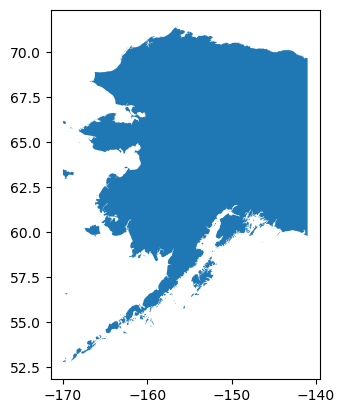

In [15]:
land_antibuffered.plot()

In [17]:
# Reproject and clip
land_antibuffered = land_antibuffered.to_crs(cavm_treeline_buf.crs)
cavm_treeline_buf_clipped = gpd.clip(cavm_treeline_buf, land_antibuffered)
cavm_treeline_buf_clipped = gpd.clip(cavm_treeline_buf_clipped, bbox_gdf)

### Try to split buffer by treeline

In [19]:
from shapely.ops import split

In [22]:
z = split(cavm_treeline_buf_clipped, cavm_treeline.to_crs(cavm_treeline_buf_clipped.crs))

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [16]:
cavm_treeline_buf_clipped.plot()

NameError: name 'cavm_treeline_buf_clipped' is not defined

In [114]:
cavm_treeline_buf_clipped.to_file(f'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/cavm_treeline_buf{BUF_KM}_land_alaska.gpkg')